## Summary

Welcome to Part 2 of the In-cloud Science Workflow workshop.

In these examples we will use the [xarray](https://xarray.dev/), [earthaccess](https://nsidc.github.io/earthaccess/), and [harmony-py](https://github.com/nasa/harmony-py) libraries to subset data and make figures using `cartopy`, `matplotlib`, and `geoviews`.

We will go through **two examples of subsetting and plotting data in the Earthdata Cloud:** 

1. Example 1 - `earthaccess` and `xarray` for precipitation estimates from [IMERG, Daily Level 3 data](https://doi.org/10.5067/GPM/IMERGDF/DAY/07)
2. Example 2 - `harmony-py` for direct cloud subsetting of precipitable water data from the [DSCOVR EPIC Composite](https://doi.org/10.5067/EPIC/DSCOVR/L2_COMPOSITE_01).
3. Appendix 1 - Snow cover data from [MODIS/Terra, Daily Level 3 data](https://doi.org/10.5067/MODIS/MOD10C1.061) with `rioxarray`
4. Appendix 2 - Snow mass data from [SMAP, 3-hourly Level 4 data](https://doi.org/10.5067/EVKPQZ4AFC4D)
    
In the first example, we will be accessing data directly from Amazon Web Services (AWS), specifically in the us-west-2 region, which is where all cloud-hosted NASA Earthdata reside. This shared compute environment (JupyterHub) is also running in the same location. We will then load the data into Python as an `xarray` dataset and use `xarray` to subset.

In the second example, we will demonstrate an example of pulling data via the cloud from an existing on-premise data server.  In this example, the data are subsetted using one of the data transformation services provided in the NASA Earthdata system. Both `xarray` and `harmony-py` can be run outside of AWS as well.

See the bottom of the notebook for additional resources, including several tutorials that that served as a foundation for this clinic. Includes: https://github.com/rupesh2/atmospheric_rivers/tree/main

Note: "direct cloud access" is also called "direct S3 access" or simply "direct access".

## Learning Objectives

1. Extract variables, temporal slices, and spatial slices from an `xarray` dataset 
2. Plot data and exclude data points via boolean conditions, using `xarray`, `cartopy`, `matplotlib`, and `rasterio`
3. Plot a polygon geojson file with a basemap using `geoviews` 
4. Conceptualize data subsetting services provided by NASA Earthdata, including Harmony
5. Utilize the `harmony-py` library to request data over the Bay of San Francisco

### Import Required Packages

In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
from pprint import pprint

# Example 1 imports
import earthaccess
import xarray as xr
xr.set_options(display_expand_attrs=False)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Example 2 imports (Example 1 imports plus these...)
import datetime as dt
import json
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import geopandas as gpd
import geoviews as gv
gv.extension('bokeh', 'matplotlib', logo=False)
from harmony import Client, Collection, Request, CapabilitiesRequest

# Appendix 1 imports
from pathlib import Path
import rioxarray as rxr

%matplotlib inline

## Picking up where we left off

We will authenticate our Earthaccess session, and then open the results like we did in the Search & Discovery section.

In [2]:
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 01/26/2024
Using .netrc file for EDL


## Example 1 - Xarray Subsetting - Precipitation estimates from IMERG, Daily Level 3

### Dataset
We will use the GPM IMERG Final Precipitation L3 Daily dataset for this tutorial.  The IMERG Precipitation Rate provides the rain and snow rates in millimeters per hour (mm/hr). It is estimated by the Integrated Multi-satellitE Retrievals for Global Precipitation Measurement (GPM) (IMERG) algorithm. The IMERG algorithm uses passive-microwave data from the GPM constellation of satellites and infrared data from geosynchronous satellites. IMERG “morphs” observations to earlier or later times using wind from weather-model analyses. The daily IMERG dataset is derived from the half-hourly GPM_3IMERGHH. The derived result represents the final estimate of the daily mean precipitation rate in mm/day.

The IMERG data has 0.1 x 0.1 degree latitude-longitude resolution (approximately 11 by 11 km at the Equator). The grid covers the globe, although precipitation cannot always be estimated near the Poles. The dataset and algorithm are described in the [data user guide](https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/doc/README.GPM.pdf) and the [Algorithm Theoretical Basis Document (ATBD)](https://arthurhou.pps.eosdis.nasa.gov/Documents/IMERG_V07_ATBD_final.pdf). 

Please cite the dataset as:
> Huffman, G.J., E.F. Stocker, D.T. Bolvin, E.J. Nelkin, Jackson Tan (2023), GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 degree V07, Edited by Andrey Savtchenko, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), https://doi.org/10.5067/GPM/IMERGDF/DAY/07

In [3]:
collection_id = 'C2723754864-GES_DISC'  # GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 degree V07 (GPM_3IMERGDF)

# Bounds within which we search for data granules
# min lon, min lat, max lon, max lat

# For reference (e.g., to visualize in https://geojson.io/), here is a GeoJSON representing the above bounding box:
# {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "LineString", "bbox": [-127.0761, 31.6444, -113.9039, 42.631], "coordinates": [[-113.9039, 42.631], [-127.0761,42.631], [-127.0761, 31.6444], [-113.9039, 31.6444], [-113.9039, 42.631]]}}]}

Granules found: 3
 Opening 3 granules, approx size: 0.08 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

Note that `xarray` works with "lazy" computation whenever possible. In this case, the metadata are loaded into JupyterHub memory, but the data arrays and their values are not — until there is a need for them.

Let's print out all the variable names.

Of the variables listed above, we are interested in three variables: `precipitation`, `precipitation_cnt_cond`, and `probabilityLiquidPrecipitation`. Let's print their attributes.

### Subsetting

In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection/regridding, and file aggregation. What does subsetting mean? To **subset** means to extract only the portions of a dataset that are needed for a given purpose. Here's a generalized graphic of what we mean. 

![](https://github.com/NASA-Openscapes/earthdata-cloud-cookbook/blob/main/examples/images/subsetting_diagram.png?raw=true){fig-alt="Three maps of the United States are present, with a red bounding box over the state of Colorado. Filtering and subsetting are demonstrated by overlaying SMAP L2 data, with data overlapping and cropping the rectangle, respectively."  width=60%}

There are three primary types of subsetting that we will walk through: 
1. Temporal
2. Spatial
3. Variable

In each case, we will be excluding parts of the dataset that are not wanted using `xarray`. Note that "subsetting" is also called a data "transformation".

We start with a subset that represents the U.S. state of California.  Notice the dimensions of the Dataset and each variable — time, lon, lat, and 'nv' (number of vertices) for the bounds variable.

In [1]:
# Display the full dataset's metadata


Now we will prepare a subset. We're using essentially the same spatial bounds as above; however, as opposed to the `earthaccess` inputs above, here we must provide inputs in the formats expected by `xarray`. Instead of a single, four-element, bounding box, we use Python `slice` objects, which are defined by starting and ending numbers.

Notice the differences?

### Plotting

We will first plot using the methods built-in to the `xarray` package.

Note that, as opposed to the "lazy" loading of metadata previously, this will now perform "eager" computation, pulling the required data chunks.

Now let's utilize the "Probability of liquid precipitation phase" (`probabilityLiquidPrecipitation`) variable to split apart the snow precipitation from everything else. From the variable's description attribute, we can see that "0=missing values; 1=likely solid; 100=likely liquid or no precipitation".

Moreover, we'll utilize `precipitation_cnt_cond` to filter out data points that had less than 0.01 mm/hr preciptation amounts.

In the following plotting commands, we utilize `cartopy` and `matplotlib` to generate a more customized figure. 

`cartopy` is used to set the map projection (to PlateCarree) and to add U.S. state boundary lines to the figure. `matplotlib`'s pcolormesh is used to generate the color plot, with colors determined by the third argument's value.

In [2]:
# create the plot


Notice the enhancements?

## Example 2 - Harmony-py Subsetting - Precipitable Water from DSCOVR-EPIC Composite

### Dataset
The NASA Earth Polychromatic Imaging Camera (EPIC)-view Multi-Sensor Global Cloud and Radiance Composites are generated by optimally merging together multiple imagers on low Earth orbit (LEO) satellites (including MODIS, VIIRS, and AVHRR) and geostationary (GEO) satellites (including GOES-13 and -15, METEOSAT-7 and -10, MTSAT-2, and Himawari-8). These provide a seamless global composite product at 5-km resolution by using an aggregated rating that considers five parameters (nominal satellite resolution, pixel time relative to the Earth Polychromatic Imaging Camera (EPIC) observation time, viewing zenith angle, distance from day/night terminator, and sun glint factor) and selects the best observation at the time nearest to the EPIC measurements. The global composite data are then remapped into the EPIC Field of View (FOV) by convolving the high-resolution cloud properties with the EPIC point spread function (PSF) defined with a half-pixel accuracy to produce the EPIC composite. PSF-weighted radiances and cloud properties averages are computed separately for each cloud phase. Ancillary data (i.e., surface type, snow and ice map, skin temperature, precipitable water, etc.) needed for anisotropic factor selections are also included in the composite. These composite images are produced for each observation time of the EPIC instrument (typically 300 to 600 composites per month, or every 1 to 3 hours).


The dataset and development of the composite product is described in the [Khlopenkov et al., 2017](https://doi.org/10.1117/12.2278645) and the [Product Description page](http://doi.org/10.5067/EPIC/DSCOVR/L2_COMPOSITE_01). This dataset can also be viewed in [Earthdata Search](https://cmr.earthdata.nasa.gov/search/concepts/C1576365803-LARC_ASDC.html). 

Please cite the dataset as:
> NASA/LARC/SD/ASDC. (2017). EPIC-view satellite composites for DSCOVR, Version 1 [Data set]. NASA Langley Atmospheric Science Data Center DAAC. Retrieved from https://doi.org/10.5067/EPIC/DSCOVR/L2_COMPOSITE_01.

### Harmony

[Harmony](https://www.earthdata.nasa.gov/learn/articles/harmony-in-the-cloud) is the behind-the-scenes orchestrator for much of the cloud-based transformations happening on NASA's [Earthdata Search](https://search.earthdata.nasa.gov/search) interface. However, requests can also be sent directly to Harmony in a programmatic fashion, either through use of the `harmony-py` Python library or through transmitting underlying HTTP requests.  In this example, we demonstrate the use of `harmony-py`, which was created as an alternative to Harmony's RESTful Application Programming Interface (API) and to make it more convenient to invoke Harmony directly from a Python environment, such as Jupyter notebooks or larger Python applications.

Note that additional examples can be found on the `harmony-py` GitHub page [here](https://github.com/nasa/harmony-py/tree/main).

First we need to instantiate a `Client` object, with which we will be able to interact with Harmony.

#### Inspecting a data collection for its capabilities and variables

With harmony-py, you can request a report of the capabilities that are configured for a given collection. We use that function here to inspect the DSCOVR EPIC-view Composite collection.

This data collection has one "service" associated with it, which provides several subsetting capabilities.

We can also see the list of variables associated with this data collection.

The subsetter service capabilities told us what the service is capable of "in general". How about the capabilities reported for this data collection in particular?

Notice the `True`s and the `False`s?

### Subsetting

#### Define an area of interest

For this example, we will use a GeoJSON to specify a non-rectangular region instead of a simpler, rectangular bounding box.  We will use the GeoJSON that defines a region around San Francisco.

In [3]:
# Read the GeoJSON into a GeoDataFrame


Here we illustrate the use of GeoViews, which is another open source data visualization library, like `matplotlib`. GeoViews is designed to work well with netCDF data, as well as Geopandas dataframes.  The syntax for Geoviews is different in several ways — e.g., the dataset is often specified as the first argument and different components are combined using the `*` symbol.

In [4]:
# We define a Geoview Point so we can visualize the area of interest in relation to San Francisco


# Generate an image
base = gv.tile_sources.EsriImagery.opts(width=650, height=500)
ocean_map = gv.Polygons(gdf).opts(line_color='yellow', line_width=5, color=None)

base * ocean_map * cities_lonlat.options(size=20, color='red', marker='x')

NameError: name 'gv' is not defined

#### Build a Harmony subsetting request

A Harmony request can include spatial, temporal, and variable subsetting all in the same request.  Here we will request all three types of subsetting to be performed on the EPIC-view Composite dataset.

While this processes, we can discuss the harmony job in some more detail. First, note that this request is identical to what can be achieved through NASA's Earthdata Search interface, such as this URL: [https://search.earthdata.nasa.gov/search/granules?p=C1576365803-LARC_ASDC!C1576365803-LARC_ASDC&pg[1][a]=1576368528!1576368575!LARC_ASDC&pg[1][v]=t&pg[1][gsk]=-start_date&pg[1][m]=harmony0&pg[1][of]=application/x-netcdf4&pg[1][ets]=t&pg[1][ess]=t&q=C1576365803-LARC_ASDC&sb[0]=-123.99609%2C37.19991%2C-120.44531%2C38.78263&qt=2016-02-24T12%3A00%3A00.000Z%2C2016-02-24T23%3A00%3A00.000Z&tl=1702228562!3!!&lat=37.8270894268111&long=-130.67578125&zoom=4](https://search.earthdata.nasa.gov/search/granules?p=C1576365803-LARC_ASDC!C1576365803-LARC_ASDC&pg[1][a]=1576368528!1576368575!LARC_ASDC&pg[1][v]=t&pg[1][gsk]=-start_date&pg[1][m]=harmony0&pg[1][of]=application/x-netcdf4&pg[1][ets]=t&pg[1][ess]=t&q=C1576365803-LARC_ASDC&sb[0]=-123.99609%2C37.19991%2C-120.44531%2C38.78263&qt=2016-02-24T12%3A00%3A00.000Z%2C2016-02-24T23%3A00%3A00.000Z&tl=1702228562!3!!&lat=37.8270894268111&long=-130.67578125&zoom=4)

(Futher information and examples can be found in the `harmony-py` repository, such as [this introductory notebook](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb).)

#### Request Parameters

In addition to the above request parameters, other advanced parameters may be of interest. Note that many reformatting or advanced projection options may not be available for your requested dataset. See the documentation for details on how to construct these parameters.

- `crs`: Reproject the output coverage to the given CRS. Recognizes CRS types that can be inferred by gdal, including EPSG codes, Proj4 strings, and OGC URLs (http://www.opengis.net/def/crs/%E2%80%A6)
- `interpolation`: specify the interpolation method used during reprojection and scaling
- `scale_extent`: scale the resulting coverage either among one axis to a given extent
- `scale_size`: scale the resulting coverage either among one axis to a given size
- `granule_id`: The CMR Granule ID for the granule (file) which should be retrieved
- `width`: number of columns to return in the output coverage
- `height`: number of rows to return in the output coverage
- `format`: the output mime type to return
- `max_results`: limits the number of input files processed in the request

#### Harmony Client

There are four options for providing your Earthdata Login token or username and password when creating a Harmony Client:

1. Provide EDL token using environment variable, e.g.:

> `$ export EDL_TOKEN='my_eld_token'`

2. Provide your username and password directly when creating the client:

> `harmony_client = Client(auth=('captainmarvel', 'marve10u5'))`

3. Set your credentials using environment variables:

You can either export these directly:

> `$ export EDL_USERNAME='captainmarvel'`

> `$ export EDL_PASSWORD='marve10u5'`

Or by storing them in a .env file, which operates in a similar fashion to .netrc. You will need to store the file in your current working directory and it must be named .env with the following format:

> `EDL_USERNAME=myusername`

> `EDL_PASSWORD=mypass`

4. Use a .netrc file:

> ```
machine urs.earthdata.nasa.gov
login captainmarvel
password marve10u5
```

### Plotting

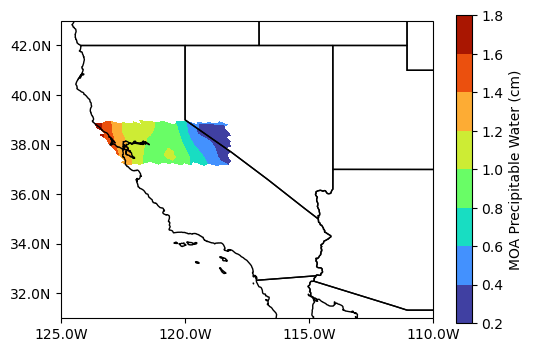

In [30]:
# Create figure
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(6, 4), facecolor="w", subplot_kw=dict(projection=proj))

ax_handle = ax.contourf(new_ds_general['lon'], new_ds_general['lat'], new_ds_general['precipitable_water'], cmap="turbo")
plt.colorbar(
    ax_handle, ax=ax, 
    label=f"{precip_attrs['long_name']} ({precip_attrs['units']})"
)

ax.add_feature(cfeature.STATES)
ax.set_extent([-125, -113.0, 31.0, 43.0], crs=proj)

ax.set_xticks([-125, -120, -115, -110], crs=proj)
ax.set_yticks([32, 34, 36, 38, 40, 42], crs=proj)
lon_formatter = LongitudeFormatter(number_format='.1f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.1f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.show()

A final note about `harmony-py`: As more transformation services are added and configured to work with existing and new NASA data collections, the capabilities you will be able to harness with `harmony-py` will also grow!

## Appendix 1 - Snow Cover from MODIS/Terra, Daily Level3

### Dataset
We will use MODIS/Terra Snow Cover Daily L3 Global 0.05Deg CMG. The Moderate Resolution Imaging Spectroradiometer (MODIS) global Level-3 (L3) data set provides the percentage of snow-covered land and cloud-covered land observed daily, within 0.05° (approx. 5 km) MODIS Climate Modeling Grid (CMG) cells. 

The dataset and algorithm is described in the [data user guide](https://nsidc.org/sites/default/files/mod10c1-v061-userguide_0.pdf) and the [Product Specific Document](https://nsidc.org/sites/default/files/c61_modis_snow_user_guide.pdf). 

Please cite the dataset as:
> Hall, D. K. and G. A. Riggs. (2021). MODIS/Terra Snow Cover Daily L3 Global 0.05Deg CMG, Version 61. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/MODIS/MOD10C1.061.

Using the dataset DOI, we will use the earthaccess module to search for dataset granules from February 24, 2023, and March 2, 2023.

In [31]:
doi = '10.5067/MODIS/MOD10C1.061' # MODIS Terra Snowcover

# search granules from Feb 15, 2023
date1 = "2023-02-15"
granules1 = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date1, date1)
)
# search granules from March 02, 2023
date2 = "2023-03-02"
granules2 = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date2, date2)
)

Granules found: 1
Granules found: 1


Let's download the granules to the local environment. This is needed as direct access to HDF4 files that MODIS Collection 6.1 comes as is currently not supported. The `earthaccess` module manages the authentication that is required for accessing data.

In [32]:
earthaccess.download(granules1, local_path='.')
earthaccess.download(granules2, local_path='.')

 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['MOD10C1.A2023061.061.2023070101022.hdf']

### Subsetting

Let's open the downloaded granules into a `rioxarray`. The variable `Day_CMG_Snow_Cover` provides daily percent snow in 5km grids. The variable `Snow_Spatial_QA` provides quality indicator for each grid: 0=best, 1=good, 2=ok, 3=poor, 4=other, 237=inland water, 239=ocean, 250=cloud obscured water 252=Antarctica mask, 253=not mapped, 254=no retrieval, and 255=fill. We will only use the grids with 0, 1, and 2 quality flags.

In [33]:
# open granule from Feb 15, 2023
g_1 = Path(Path(granules1[0].data_links()[0]).name)
if g_1.is_file():
    with rxr.open_rasterio(g_1) as modis:
        print(modis)
        snow_cover1 = modis['Day_CMG_Snow_Cover'][:]
        snow_cover_qa1 = modis['Snow_Spatial_QA'][:]

# open granules from March 02, 2023
g_2 = Path(Path(granules2[0].data_links()[0]).name)
if g_2.is_file():
    with rxr.open_rasterio(g_2) as modis:
        snow_cover2 = modis['Day_CMG_Snow_Cover'][:]
        snow_cover_qa2 = modis['Snow_Spatial_QA'][:]

# Spatially subset and keep only good quality cells
snow_cover_good1 = (
    snow_cover1
    .sel(x=slice(-125, -113), y=slice(43, 31))
    .where((snow_cover_qa1 >= 0) & (snow_cover_qa1 <= 2))
)
snow_cover_good2 = (
    snow_cover2
    .sel(x=slice(-125, -113), y=slice(43, 31))
    .where((snow_cover_qa2 >= 0) & (snow_cover_qa2 <= 2))
)

<xarray.Dataset>
Dimensions:                 (band: 1, x: 7200, y: 3600)
Coordinates:
  * band                    (band) int64 1
  * x                       (x) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * y                       (y) float64 89.97 89.92 89.88 ... -89.93 -89.98
    spatial_ref             int64 0
Data variables:
    Day_CMG_Snow_Cover      (band, y, x) uint8 ...
    Day_CMG_Clear_Index     (band, y, x) uint8 ...
    Day_CMG_Cloud_Obscured  (band, y, x) uint8 ...
    Snow_Spatial_QA         (band, y, x) uint8 ...
Attributes: (50)


### Plotting

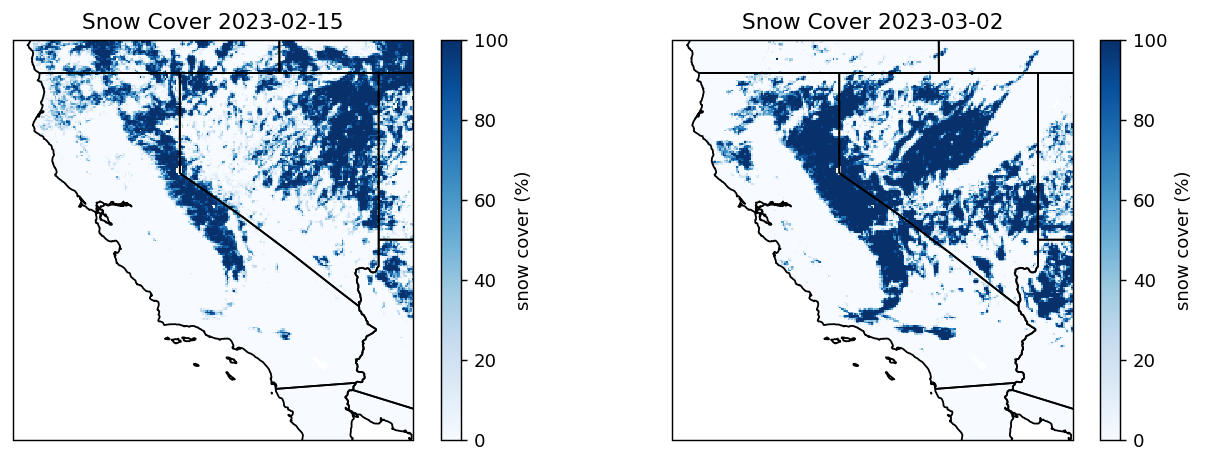

In [34]:
# create the plot
proj = ccrs.PlateCarree()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), dpi=130, facecolor="w", subplot_kw=dict(projection=proj))

snowax1 = ax1.pcolormesh(snow_cover_good1.x.values, snow_cover_good1.y.values, snow_cover_good1.values[0], vmax=100, cmap='Blues')
plt.colorbar(snowax1, ax=ax1, label="snow cover (%)")
ax1.add_feature(cfeature.STATES)
ax1.set_title(f'Snow Cover {date1}')

snowax2 = ax2.pcolormesh(snow_cover_good2.x.values, snow_cover_good2.y.values, snow_cover_good2.values[0], vmax=100, cmap='Blues')
plt.colorbar(snowax2, ax=ax2, label="snow cover (%)")
ax2.add_feature(cfeature.STATES)
ax2.set_title(f'Snow Cover {date2}')
plt.show()

## Appendix 2 - Snow Mass from SMAP, 3-hourly Level 4

### Dataset
The Soil Moisture Active Passive (SMAP) L4 Global 3-hourly 9 km EASE-Grid Surface and Root Zone Soil Moisture Geophysical Data (SPL4SMGP) provides a model-derived global 3-hr time average of snow mass in kg/m2.  SMAP L-band brightness temperature data from descending and ascending half-orbit satellite passes (approximately 6:00 a.m. and 6:00 p.m. local solar time, respectively) are assimilated into a land surface model that is gridded using an Earth-fixed, global cylindrical 9 km Equal-Area Scalable Earth Grid, Version 2.0 (EASE-Grid 2.0) projection. Snow mass estimates are based on a snow model component of the NASA Catchment Land Surface Model.

The dataset and algorithm are described in the [data user guide](https://nsidc.org/sites/default/files/documents/user-guide/multi_spl4smau-v007-userguide.pdf) and the [Product Specific Document](https://nsidc.org/sites/default/files/documents/technical-reference/reichle1438.pdf). 

Please cite the dataset as:
> Reichle, R., G. De Lannoy, R. D. Koster, W. T. Crow, J. S. Kimball, Q. Liu, and M. Bechtold. (2022). SMAP L4 Global 3-hourly 9 km EASE-Grid Surface and Root Zone Soil Moisture Geophysical Data, Version 7. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/EVKPQZ4AFC4D.

In [35]:
# SMAP SPL4SMGP
doi = '10.5067/EVKPQZ4AFC4D'

# search granules from Feb 15, 2023
date1 = "2023-02-15"
granules1 = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date1, date1)
)

# search granules from March 02, 2023
date2 = "2023-03-02"
granules2 = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date2, date2)
)

Granules found: 2
Granules found: 2


In [36]:
# granules from Feb 15, 2023
fh1 = earthaccess.open(granules1)
# open geophysical_data group
ds1 = xr.open_dataset(fh1[0], phony_dims='access', group='Geophysical_Data')
# get location
ds_loc1 = xr.open_dataset(fh1[0], phony_dims='access')

 Opening 2 granules, approx size: 0.27 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
# granules from March 02, 2023
fh2 = earthaccess.open(granules2)
# open geophysical_data group
ds2 = xr.open_dataset(fh2[0], phony_dims='access', group='Geophysical_Data')
# get location
ds_loc2 = xr.open_dataset(fh2[0], phony_dims='access')

 Opening 2 granules, approx size: 0.27 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

The "snow_mass" variable is within the "Geophysical_Data" group. It provides the average snow mass (or snow water equivalent) over a land fraction of the grid cell, excluding areas of open water and permanent ice. Let's print the attributes of the `snow_mass` variable.

In [38]:
ds1.variables['snow_mass'].attrs

{'DIMENSION_LABELS': [b'y', b'x'],
 'coordinates': '/cell_lat /cell_lon',
 'fmissing_value': -9999.0,
 'grid_mapping': 'EASE2_global_projection',
 'long_name': 'Average snow mass (or snow water equivalent) over land fraction of grid cell (excluding areas of open water and permanent ice)',
 'units': 'kg m-2',
 'valid_max': 10000.0,
 'valid_min': 0.0}

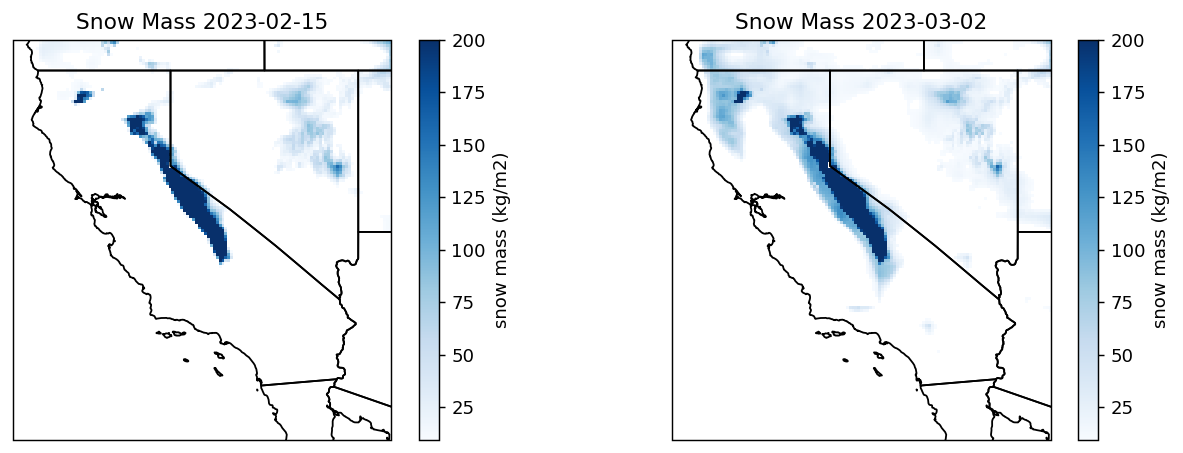

In [39]:
# create the plot
proj = ccrs.Projection("EPSG:6933") # EASEGRID 2
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), dpi=130, facecolor="w", subplot_kw=dict(projection=proj))

ca_bounds = [-12060785, -10902950, 3769089, 4995383]

snow_mass1 = ds1.snow_mass.where(ds1.snow_mass>9.4)
snowax1 = ax1.pcolormesh(ds_loc1.x, ds_loc1.y, snow_mass1, vmax=200, cmap='Blues')
plt.colorbar(snowax1, ax=ax1, label="snow mass (kg/m2)")
ax1.add_feature(cfeature.STATES)
ax1.set_extent(ca_bounds, crs=proj)
ax1.set_title(f'Snow Mass {date1}')

snow_mass2 = ds2.snow_mass.where(ds2.snow_mass>9.4)
snowax2 = ax2.pcolormesh(ds_loc2.x, ds_loc2.y, snow_mass2, vmax=200, cmap='Blues')
plt.colorbar(snowax2, ax=ax2, label="snow mass (kg/m2)")
ax2.add_feature(cfeature.STATES)
ax2.set_extent(ca_bounds, crs=proj)
ax2.set_title(f'Snow Mass {date2}')
plt.show()

### Now we will remove the saved files from our workspace, to keep it clean for future coding!

In [40]:
from glob import glob

for f in glob("DSCOVR_EPIC_L2*.nc4"):
    Path(f).unlink()
    
for f in glob("MOD10C1.*.hdf"):
    Path(f).unlink()

## Additional Resources

### Tutorials

This clinic was based off of several notebook tutorials including those presented during [past workshop events](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/tutorials/), along with other materials co-created by the NASA Openscapes mentors:
* [2021 Earthdata Cloud Hackathon](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/)
* [2021 AGU Workshop](https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/)
* [Accessing and working with ICESat-2 data in the cloud](https://github.com/nsidc/NSIDC-Data-Tutorials/tree/main/notebooks/ICESat-2_Cloud_Access)
* [Analyzing Sea Level Rise Using Earth Data in the Cloud](https://github.com/betolink/earthaccess-gallery/blob/main/notebooks/Sea_Level_Rise/SSL.ipynb)

### Cloud services

The examples used in the clinic provide an abbreviated and simplified workflow to explore access and subsetting options available through the Earthdata Cloud. There are several other options that can be used to interact with data in the Earthdata Cloud including: 

* [OPeNDAP](https://opendap.earthdata.nasa.gov/) 
    * Hyrax provides direct access to subsetting of NASA data using Python or your favorite analysis tool
    * Tutorial highlighting OPeNDAP usage: https://nasa-openscapes.github.io/earthdata-cloud-cookbook/how-tos/working-locally/Earthdata_Cloud__Data_Access_OPeNDAP_Example.html
* [Zarr-EOSDIS-Store](https://github.com/nasa/zarr-eosdis-store)
    * The zarr-eosdis-store library allows NASA EOSDIS Collections to be accessed efficiently by the Zarr Python library, provided they have a sidecar DMR++ metadata file generated. 
    * Tutorial highlighting this library's usage: https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/09_Zarr_Access.html 

### Support

* [Earthdata Forum](https://forum.earthdata.nasa.gov/)
    * User Services and community support for all things NASA Earthdata, including Earthdata Cloud
* [Earthdata Webinar series](https://www.earthdata.nasa.gov/learn/webinars-and-tutorials)
    * Webinars from DAACs and other groups across EOSDIS including guidance on working with Earthdata Cloud
    * See the [Earthdata YouTube channel](https://www.youtube.com/@NASAEarthdata/featured) for more videos 

END of Notebook.